In [39]:
import sys
print(sys.version)

import os
# 解决这个问题，下面一行代码的配置没用，Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# os.environ["LDFLAGS"] = "-L/usr/local/opt/libomp/lib"
# os.environ["CPPFLAGS"] = "-I/usr/local/opt/libomp/include"
# os.environ["DYLD_LIBRARY_PATH"] = "/usr/local/opt/libomp/lib:" + os.environ.get("DYLD_LIBRARY_PATH", "")
# os.environ["OMP_NUM_THREADS"] = "1"


3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:46:25) [Clang 18.1.8 ]


In [40]:
import torch
import torchvision
import os
from os.path import join as j_
from PIL import Image
import pandas as pd
import numpy as np

# loading all packages here to start
from uni import get_encoder
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader
from uni.downstream.eval_patch_features.linear_probe import eval_linear_probe
from uni.downstream.eval_patch_features.fewshot import eval_knn, eval_fewshot
from uni.downstream.eval_patch_features.protonet import ProtoNet, prototype_topk_vote
from uni.downstream.eval_patch_features.metrics import get_eval_metrics, print_metrics
from uni.downstream.utils import concat_images
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
from uni import get_encoder
model, transform = get_encoder(enc_name='uni2-h', device=device)

In [42]:
dataroot = '../assets/data/CRC100K/'
assert os.path.isdir('../assets/data/CRC100K/NCT-CRC-HE-100K-NONORM')
assert os.path.isdir('../assets/data/CRC100K/CRC-VAL-HE-7K')

In [43]:
import time
from uni.downstream.extract_patch_features import extract_patch_features_from_dataloader

# get path to example data
start = time.time()
dataroot = '../assets/data/CRC100K/'

# create some image folder datasets for train/test and their data laoders
# train_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'NCT-CRC-HE-100K-NONORM'), transform=transform)
test_dataset = torchvision.datasets.ImageFolder(j_(dataroot, 'CRC-VAL-HE-7K'), transform=transform)
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=False, num_workers=16)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=16)

# extract patch features from the train and test datasets (returns dictionary of embeddings and labels)
# train_features = extract_patch_features_from_dataloader(model, train_dataloader)
# torch.save(train_features, f'{dataroot}train_features.pt')
train_features = torch.load(f"{dataroot}/train_features.pt", map_location=torch.device('cpu'))
# test_features = extract_patch_features_from_dataloader(model, test_dataloader)  
# torch.save(test_features, f'{dataroot}test_features.pt')
test_features = torch.load(f"{dataroot}/test_features.pt", map_location=torch.device('cpu'))

# convert these to torch
train_feats = torch.Tensor(train_features['embeddings'])
train_labels = torch.Tensor(train_features['labels']).type(torch.long)
test_feats = torch.Tensor(test_features['embeddings'])
test_labels = torch.Tensor(test_features['labels']).type(torch.long)
elapsed = time.time() - start
print(f'Took {elapsed:.03f} seconds')

Took 8.705 seconds


In [44]:
from uni.downstream.eval_patch_features.fewshot import eval_knn

knn_eval_metrics, knn_dump, proto_eval_metrics, proto_dump = eval_knn(
    train_feats = train_feats,
    train_labels = train_labels,
    test_feats = test_feats,
    test_labels = test_labels,
    center_feats = True,
    normalize_feats = True,
    n_neighbors = 20
)

print_metrics(knn_eval_metrics)
print_metrics(proto_eval_metrics)

Test knn20_acc: 0.969
Test knn20_bacc: 0.957
Test knn20_kappa: 0.981
Test knn20_weighted_f1: 0.969
Test proto_acc: 0.884
Test proto_bacc: 0.854
Test proto_kappa: 0.910
Test proto_weighted_f1: 0.876


In [45]:
from uni.downstream.eval_patch_features.protonet import ProtoNet

# fitting the model
proto_clf = ProtoNet(metric='L2', center_feats=True, normalize_feats=True)
proto_clf.fit(train_feats, train_labels)
print('What our prototypes look like', proto_clf.prototype_embeddings.shape)

# evaluating the model
test_pred = proto_clf.predict(test_feats)
get_eval_metrics(test_labels, test_pred, get_report=False)

Num features averaged per class prototype:
	Class 0: 10407
	Class 1: 10566
	Class 2: 11512
	Class 3: 11557
	Class 4: 8896
	Class 5: 13536
	Class 6: 8763
	Class 7: 10446
	Class 8: 14317
Applying centering...
Applying normalization...
What our prototypes look like torch.Size([9, 1536])


{'acc': 0.8838440111420612,
 'bacc': 0.8539159622960268,
 'kappa': 0.9101360684446935,
 'weighted_f1': 0.8759136573096276}

label2idx correspondenes {'ADI': 0, 'BACK': 1, 'DEB': 2, 'LYM': 3, 'MUC': 4, 'MUS': 5, 'NORM': 6, 'STR': 7, 'TUM': 8}
Top-k ADIPOSE-like test samples to ADIPOSE prototype


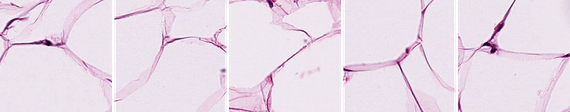

Top-k LYMPHOCYTE-like test samples to LYMPHOCYTE prototype


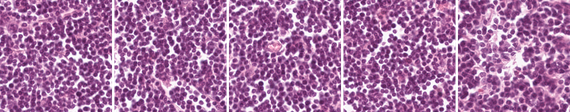

Top-k MUCOSA-like test samples to MUCOSA prototype


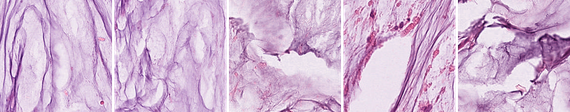

Top-k MUSCLE-like test samples to MUSCLE prototype


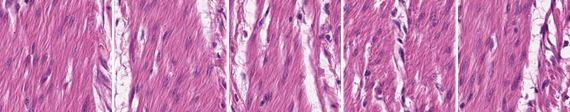

Top-k NORMAL-like test samples to NORMAL prototype


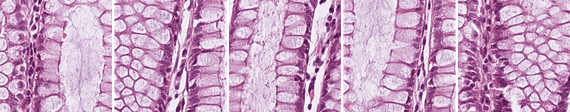

Top-k STROMA-like test samples to STROMA prototype


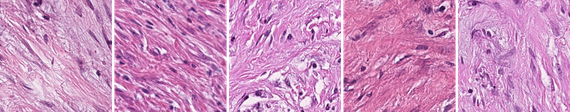

Top-k TUMOR-like test samples to TUMOR prototype


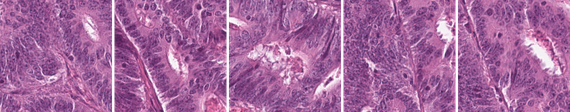

In [46]:
dist, topk_inds = proto_clf._get_topk_queries_inds(test_feats, topk=5)
print('label2idx correspondenes', test_dataset.class_to_idx)
test_imgs_df = pd.DataFrame(test_dataset.imgs, columns=['path', 'label'])

# print("===============")
# del proto_clf
# print("1111")
# del test_labels
# print("2222")
# del test_feats
# print("3333")
# del train_labels
# print("44444")
# del train_feats
# print("5555")
# gc.collect()

print('Top-k ADIPOSE-like test samples to ADIPOSE prototype')
adi_topk_inds = topk_inds[0]
# print(adi_topk_inds)
# print("--------------")
# [print(img_fpath) for img_fpath in test_imgs_df['path'][adi_topk_inds]]
# print(test_imgs_df['path'][adi_topk_inds])
adi_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][adi_topk_inds]], scale=0.5, gap=5)
display(adi_topk_imgs)

print('Top-k LYMPHOCYTE-like test samples to LYMPHOCYTE prototype')
lym_topk_inds = topk_inds[3]
lym_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][lym_topk_inds]], scale=0.5, gap=5)
display(lym_topk_imgs)

print('Top-k MUCOSA-like test samples to MUCOSA prototype')
muc_topk_inds = topk_inds[4]
muc_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][muc_topk_inds]], scale=0.5, gap=5)
display(muc_topk_imgs)

print('Top-k MUSCLE-like test samples to MUSCLE prototype')
mus_topk_inds = topk_inds[5]
mus_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][mus_topk_inds]], scale=0.5, gap=5)
display(mus_topk_imgs)

print('Top-k NORMAL-like test samples to NORMAL prototype')
norm_topk_inds = topk_inds[6]
norm_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][norm_topk_inds]], scale=0.5, gap=5)
display(norm_topk_imgs)

print('Top-k STROMA-like test samples to STROMA prototype')
str_topk_inds = topk_inds[7]
str_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][str_topk_inds]], scale=0.5, gap=5)
display(str_topk_imgs)

print('Top-k TUMOR-like test samples to TUMOR prototype')
tum_topk_inds = topk_inds[8]
tum_topk_imgs = concat_images([Image.open(img_fpath) for img_fpath in test_imgs_df['path'][tum_topk_inds]], scale=0.5, gap=5)
display(tum_topk_imgs)
